In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import rpy2

/Users/vidyaajay/Desktop/cscb/final_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")
sc.settings.set_figure_params(figsize=(5, 5))

In [9]:
adata = sc.read_h5ad("PBMC_simCNV_2.h5ad")

In [12]:
adata = adata[:, adata.var.dropna().index]

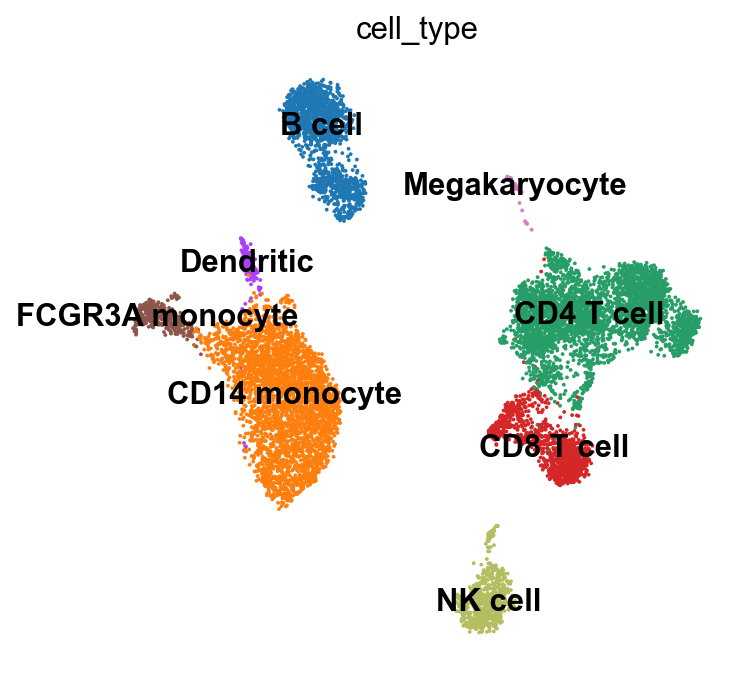

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
ribo_prefix = ("RPS", "RPL")
adata.var['ribo'] = adata.var_names.str.startswith(ribo_prefix)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

#filtering for mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < 20,:].copy()

#filtering based on total number of genes detected
sc.pp.filter_cells(adata, min_genes=500)

#filtering based on total counts
sc.pp.filter_cells(adata, max_counts=30000)

#last, filtering for genes that are detected in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

#normalizing the counts data and identifying the highly variable genes
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.25)

#do pca on the highly variable genes
sc.tl.pca(adata, mask_var='highly_variable')
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=25)
sc.tl.leiden(adata, resolution= 0.1)
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type", legend_loc="on data", frameon=False)

In [19]:
# make sure the column is string‑typed
adata.var["chromosome"] = adata.var["chromosome"].astype(str)

# add the prefix where it is missing
needs_prefix = ~adata.var["chromosome"].str.startswith("chr")
adata.var.loc[needs_prefix, "chromosome"] = (
    "chr" + adata.var.loc[needs_prefix, "chromosome"]
)

# optional: unify mitochondrial naming
adata.var["chromosome"].replace({"chrMT": "chrM", "MT": "chrM"}, inplace=True)
# List of standard chromosomes
standard_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY", "chrM"]

# Filter genes to only those on standard chromosomes
mask = adata.var["chromosome"].isin(standard_chroms)
adata = adata[:, mask]


In [21]:
adata.var.chromosome.unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chrX',
       'chr8', 'chr9', 'chr11', 'chr10', 'chr12', 'chr13', 'chr14',
       'chr15', 'chr16', 'chr17', 'chr18', 'chr20', 'chr19', 'chrY',
       'chr22', 'chr21'], dtype=object)

In [23]:
#IMPORTANT: filter out alt / patch contigs
canonical_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY", "chrM"]

#give'chromosome' an ordered categorical dtype
chrom_dtype = pd.api.types.CategoricalDtype(categories=canonical_chroms, ordered=True)
adata.var["chromosome"] = adata.var["chromosome"].astype(chrom_dtype)
adata.var["start"] = pd.to_numeric(adata.var["start"], errors="coerce")

#sort by chromosome, then by start coordinate
adata.var.sort_values(["chromosome", "start"], inplace=True)

#reorder the expression matrix so X matches var
adata = adata[:, adata.var.index].copy()


In [45]:
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    reference_cat=[
        "B cell", "Megakaryocyte", "FCGR3A monocyte", "CD14 monocyte",
        "CD4 T cell", "CD8 T cell", "Dendritic", "NK cell",
    ],
    window_size=100,
)


100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


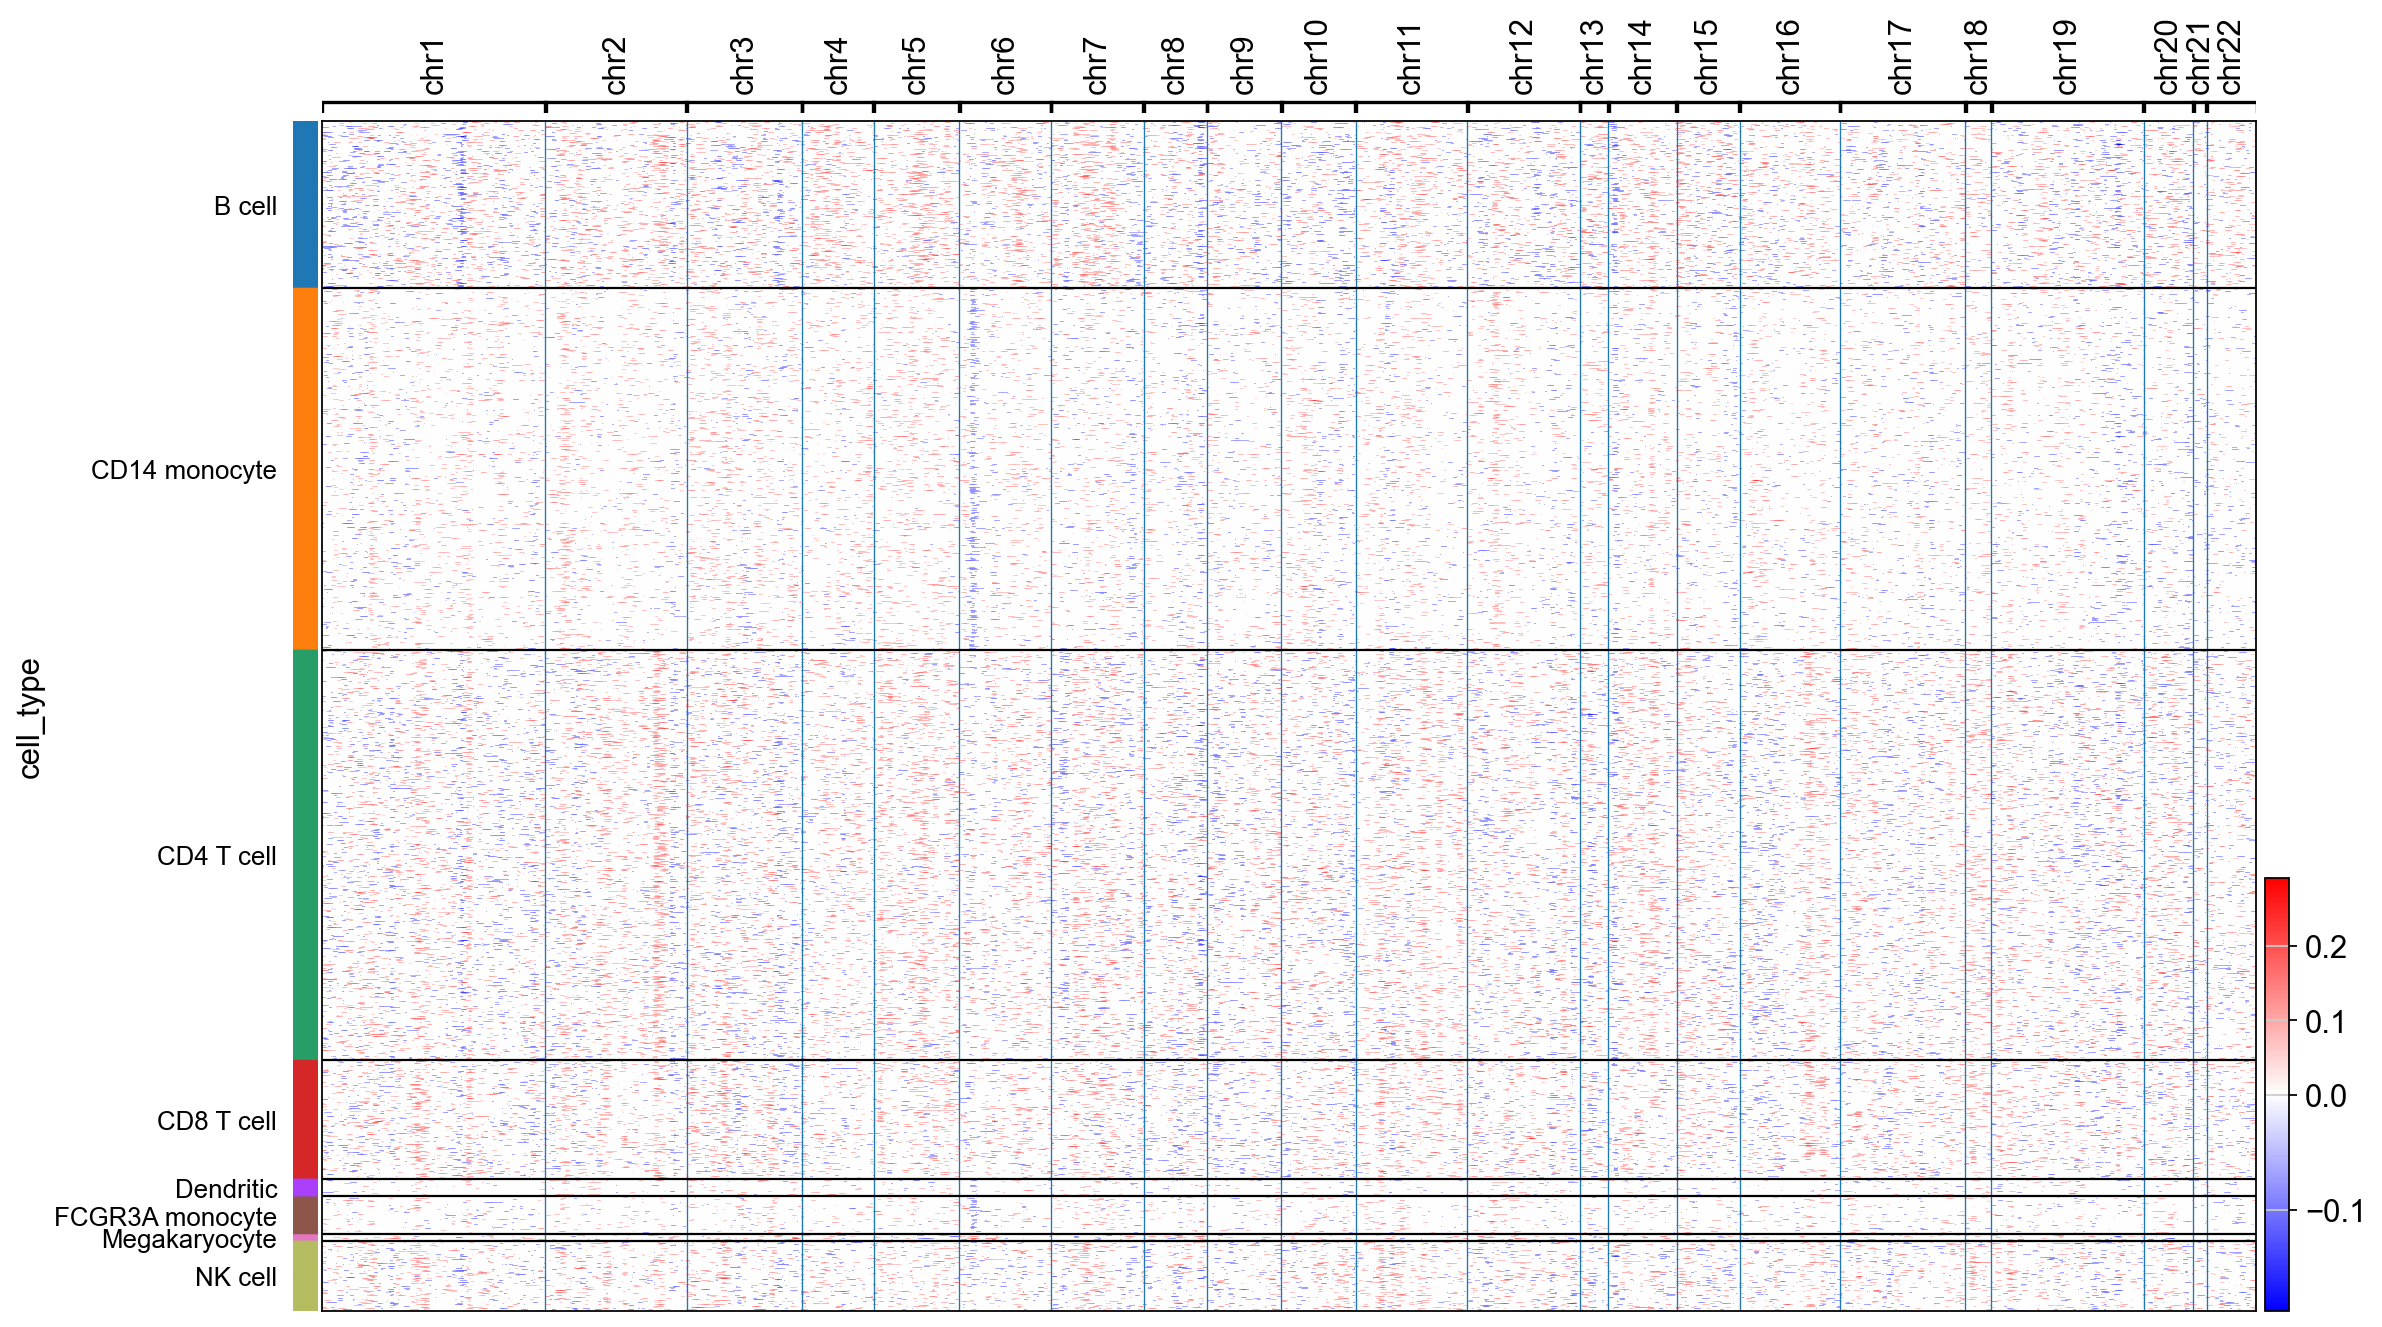

In [46]:
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

In [ ]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata, resolution = 1)

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


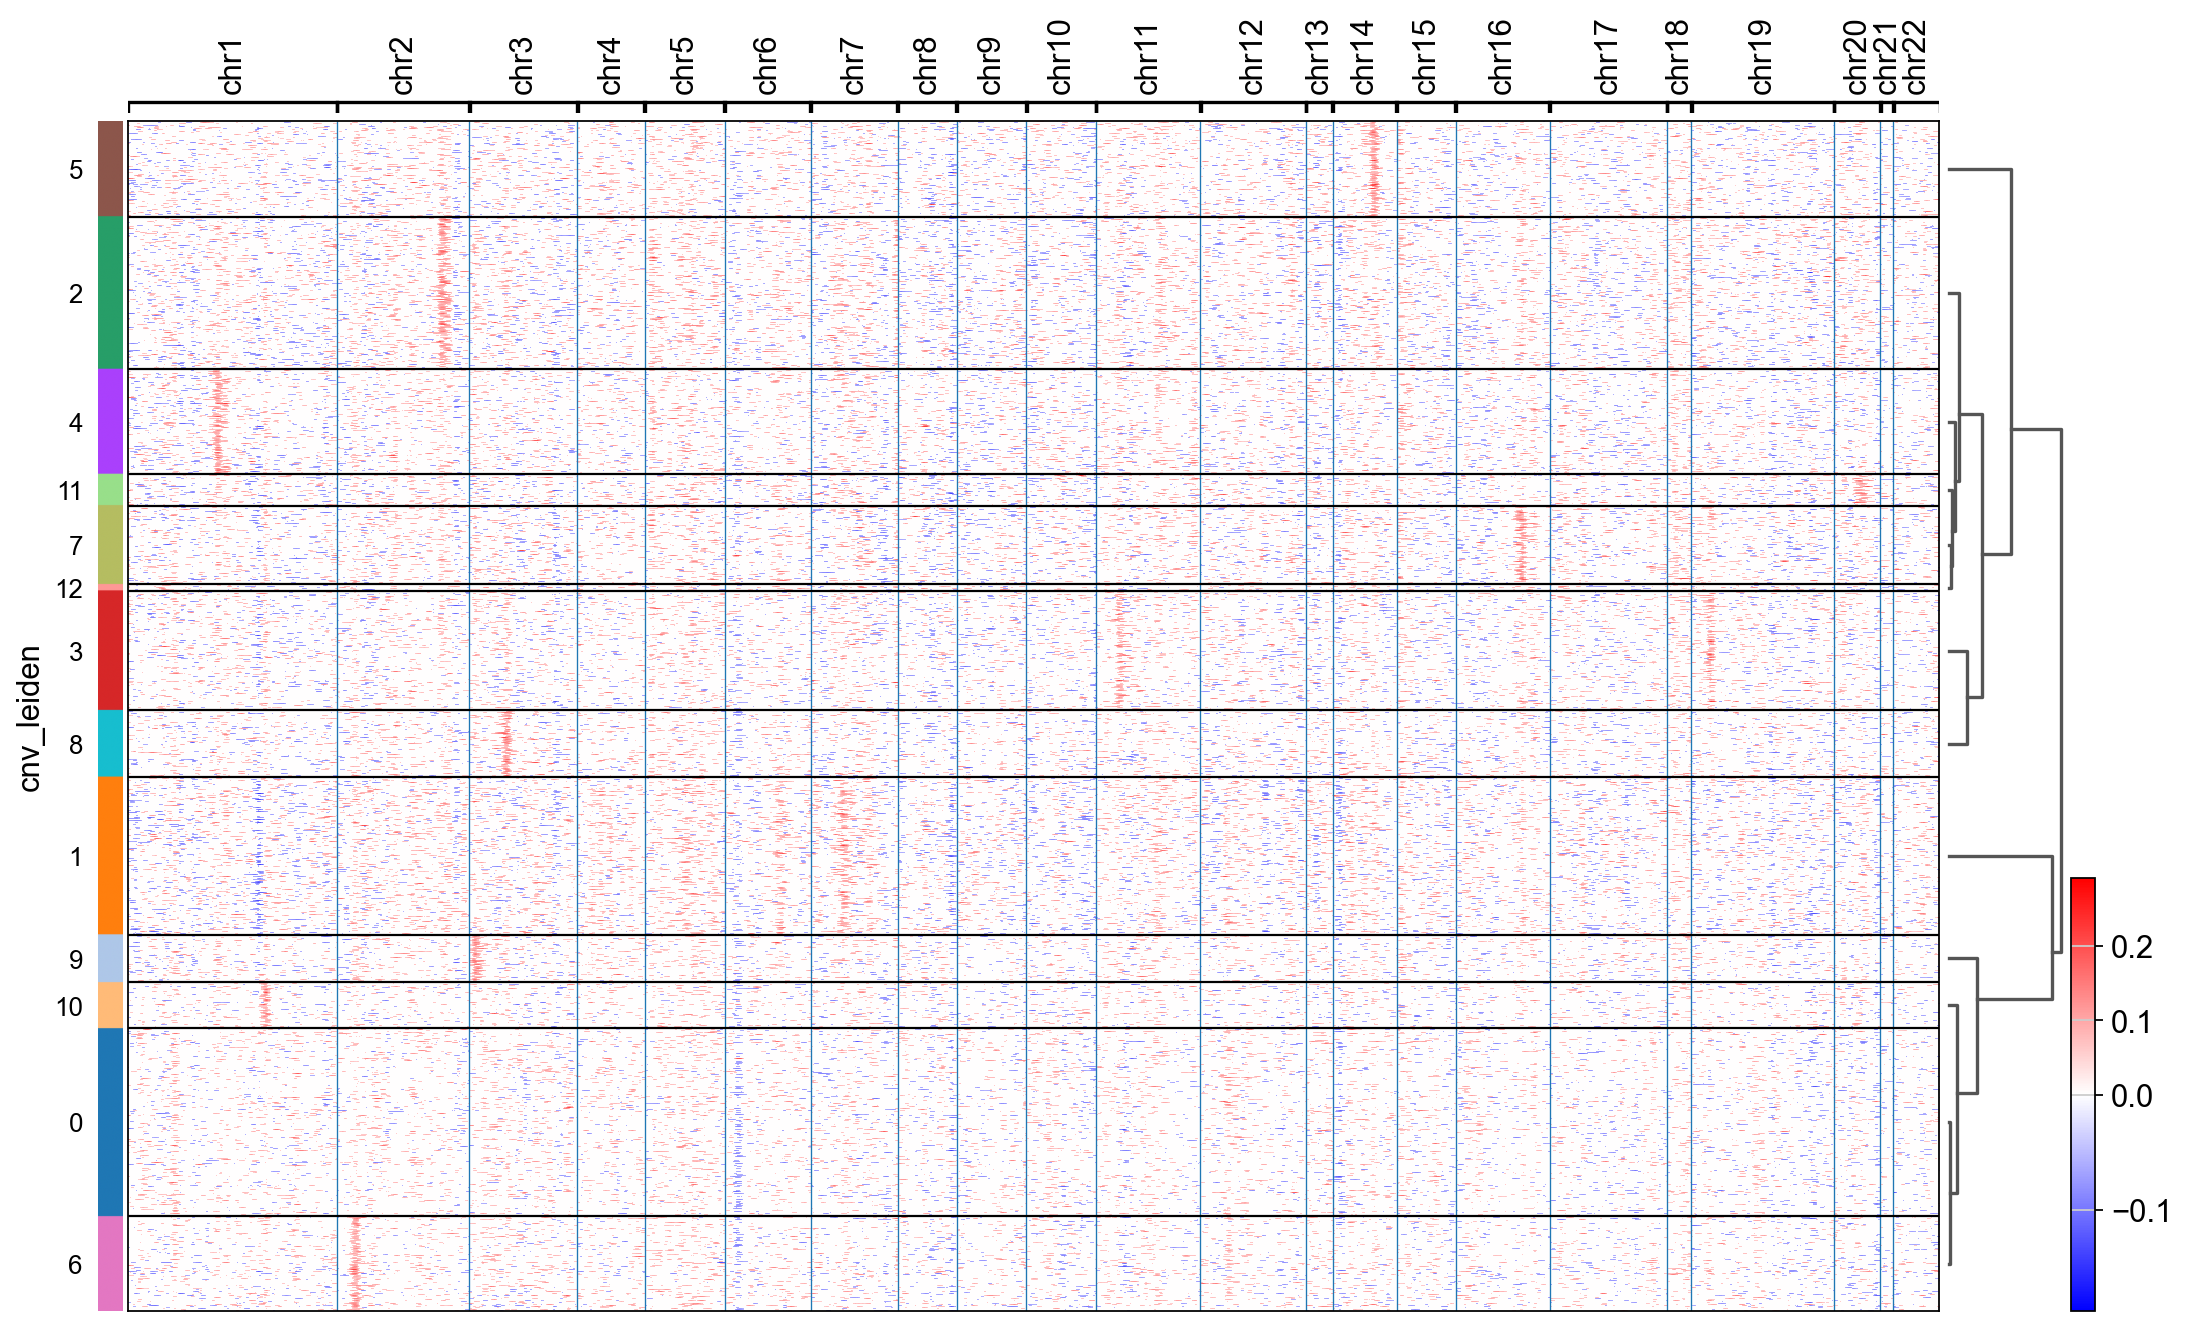

In [53]:
sc.tl.dendrogram(adata, groupby="cnv_leiden")
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)


In [54]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

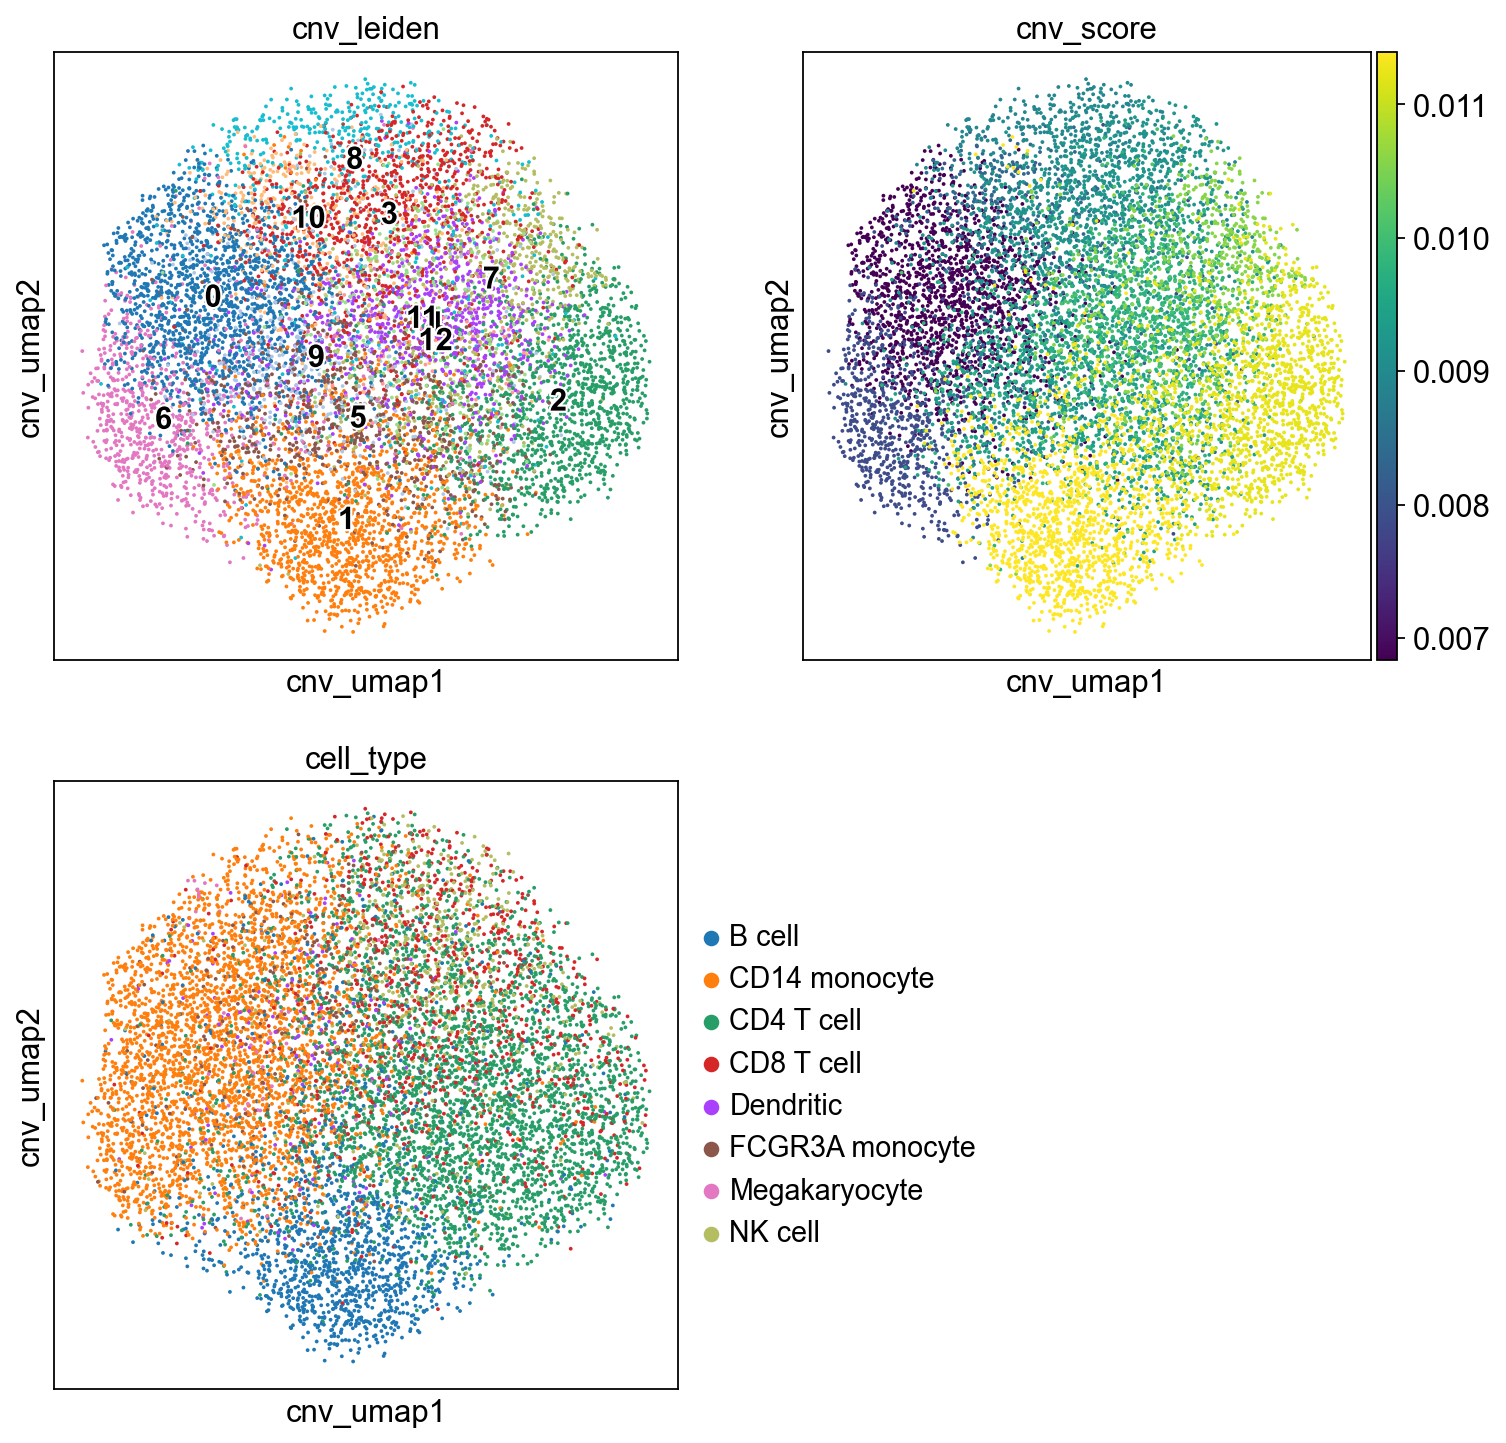

In [55]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

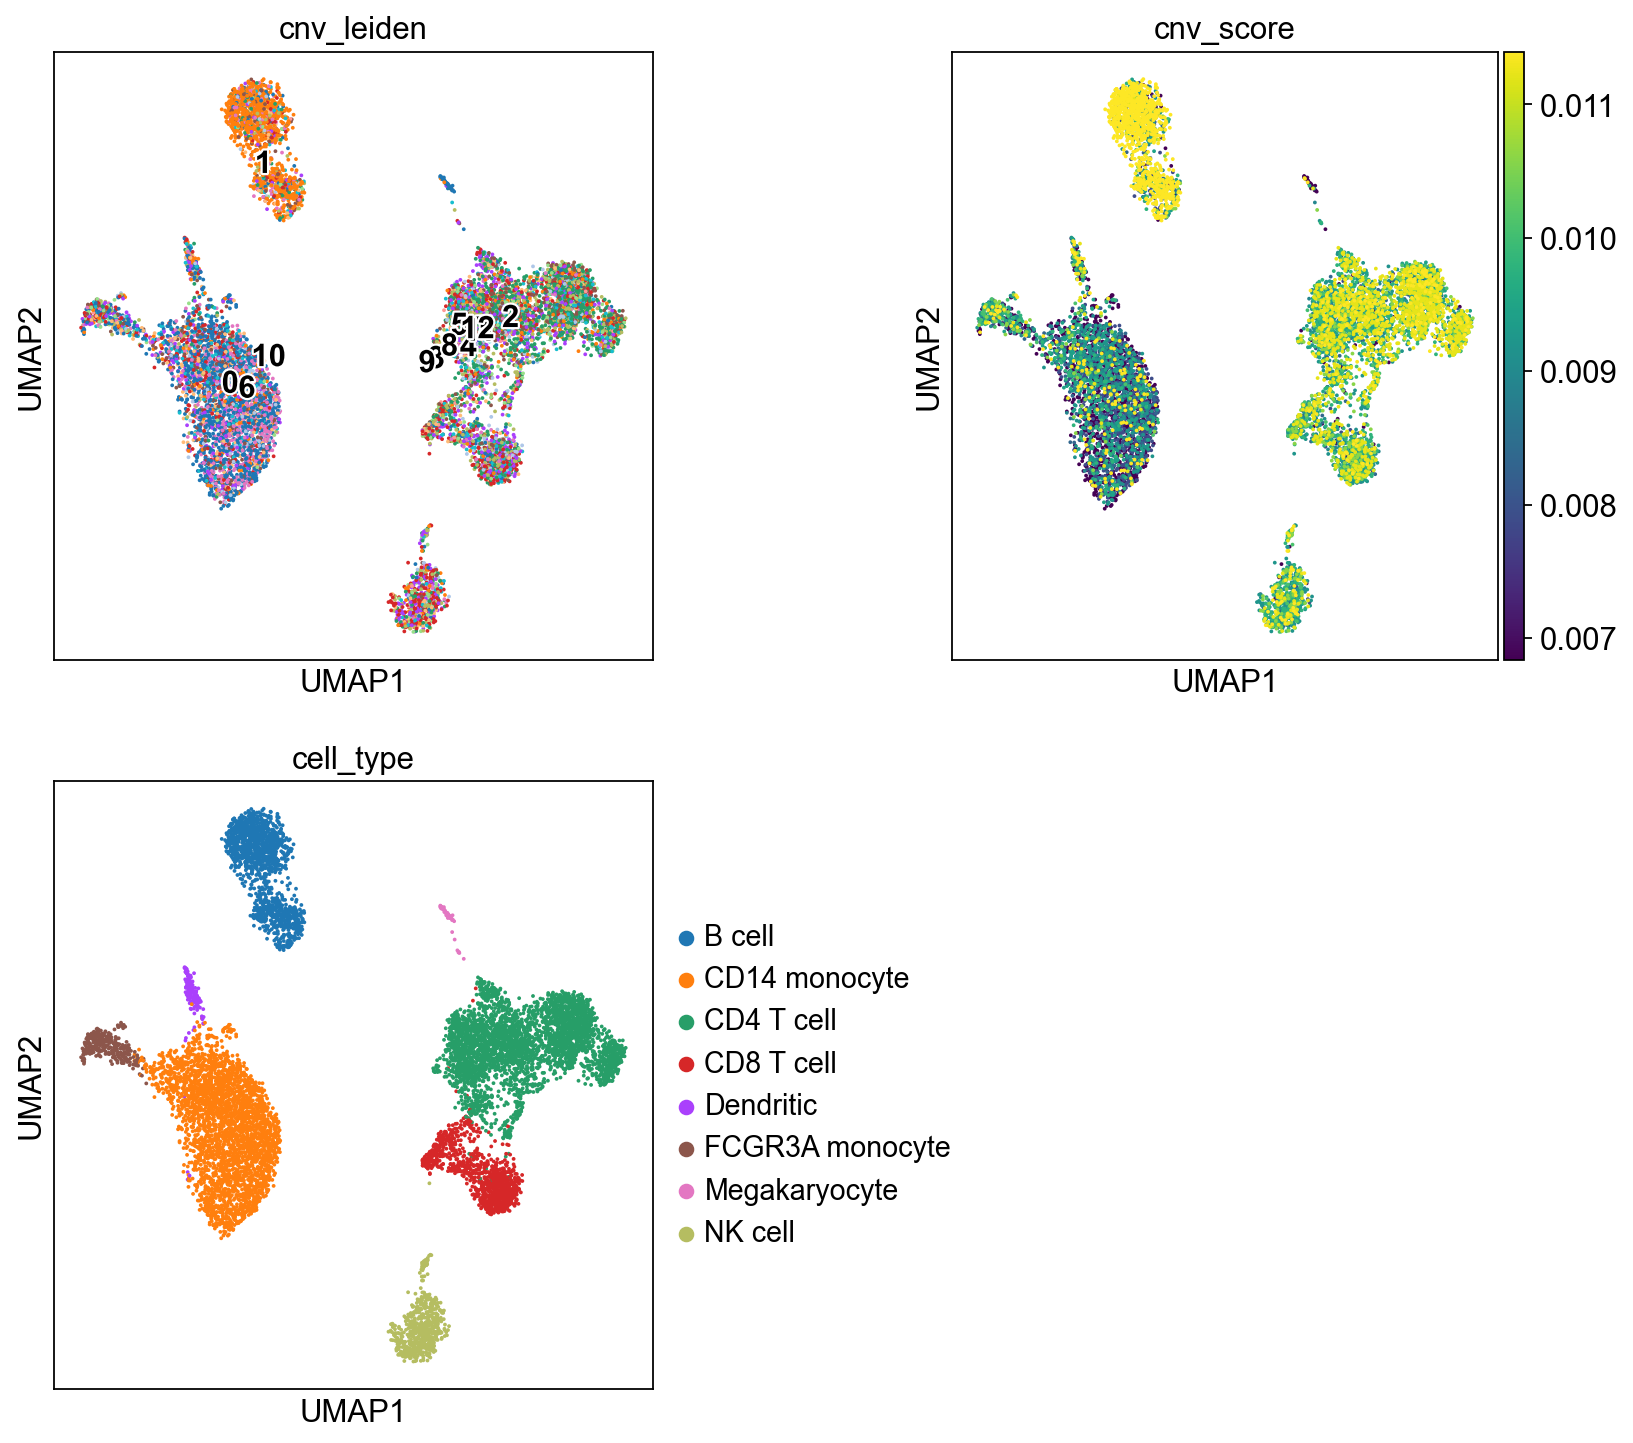

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1,    legend_loc="on data",legend_fontoutline=2, show=False)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata, color="cell_type", ax=ax3)

In [66]:
adata.obs["cnv_calls"] = "normal"
adata.obs.loc[adata.obs["cnv_leiden"].isin(["1", "2", "5"]), "cnv_calls"] = (
    "tumor"
)

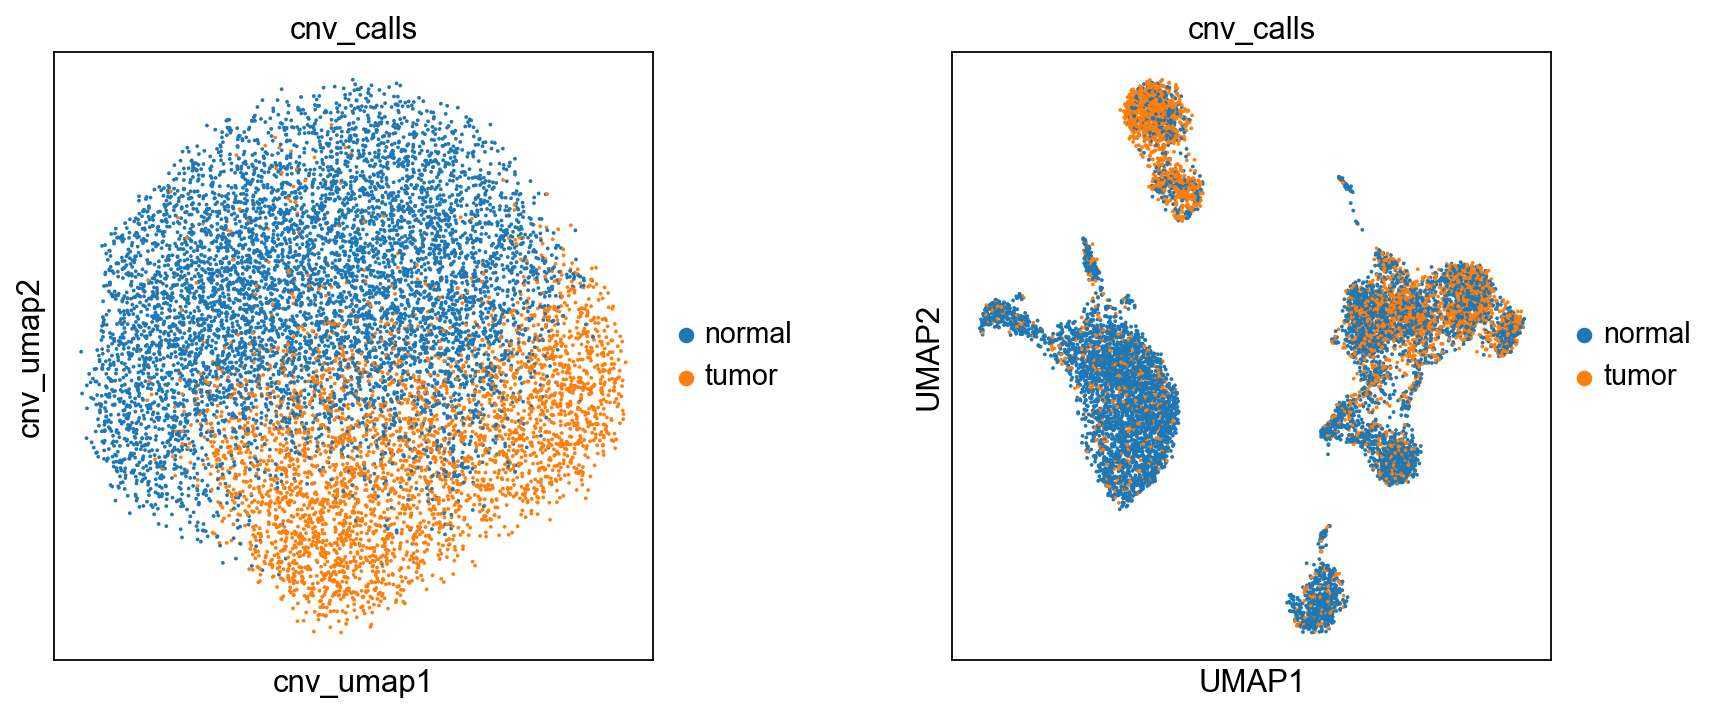

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"wspace": 0.5})
cnv.pl.umap(adata, color="cnv_calls", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_calls", ax=ax2)

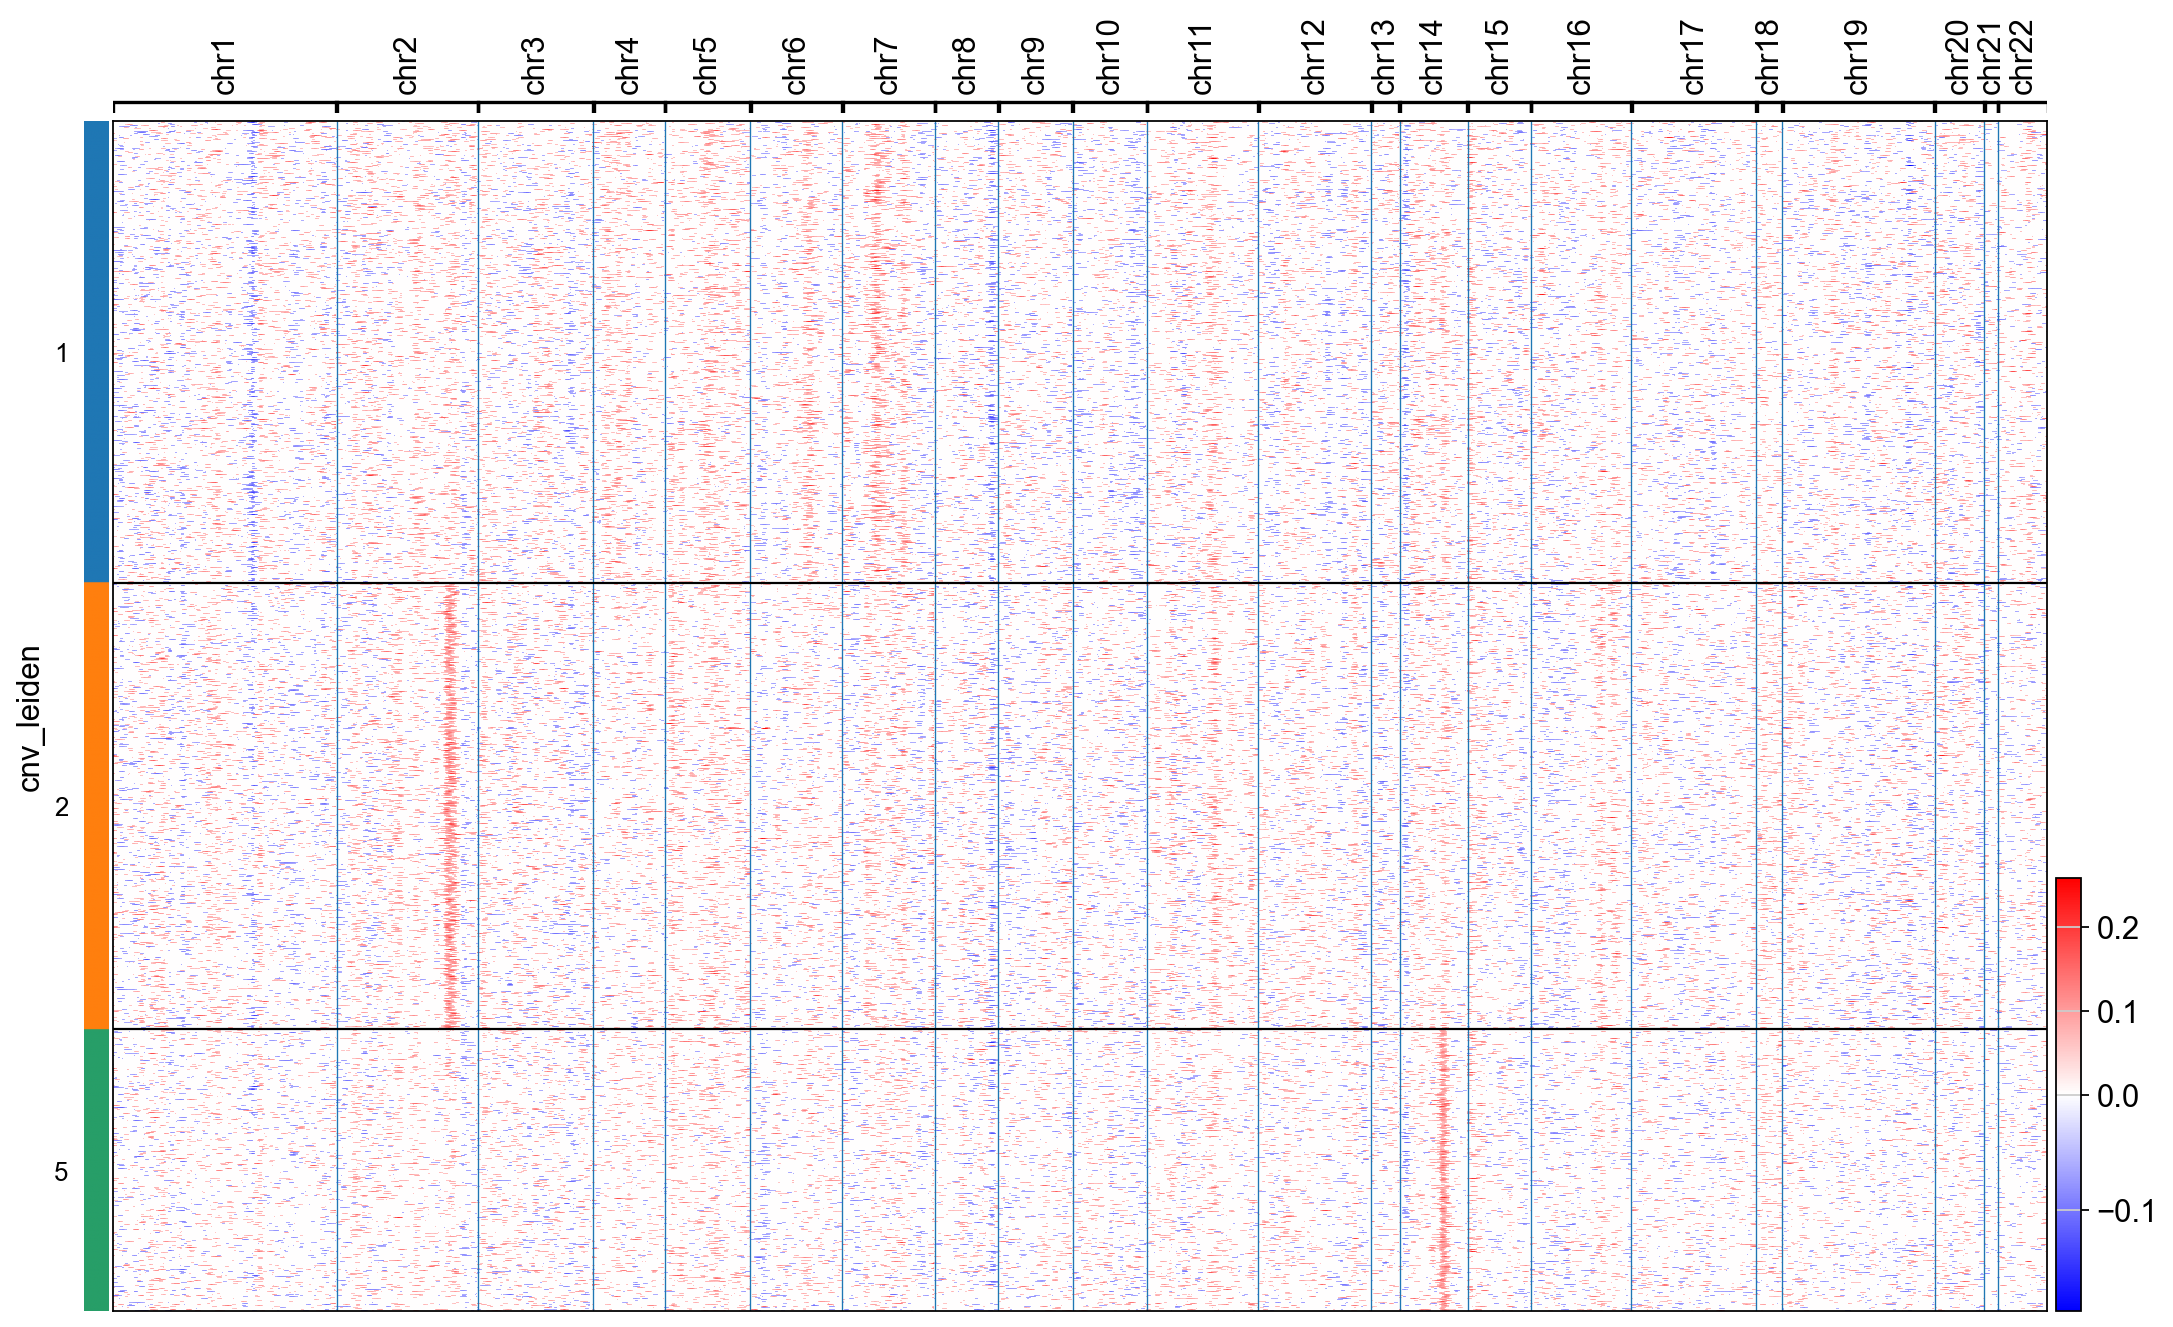

In [68]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_calls"] == "tumor", :])

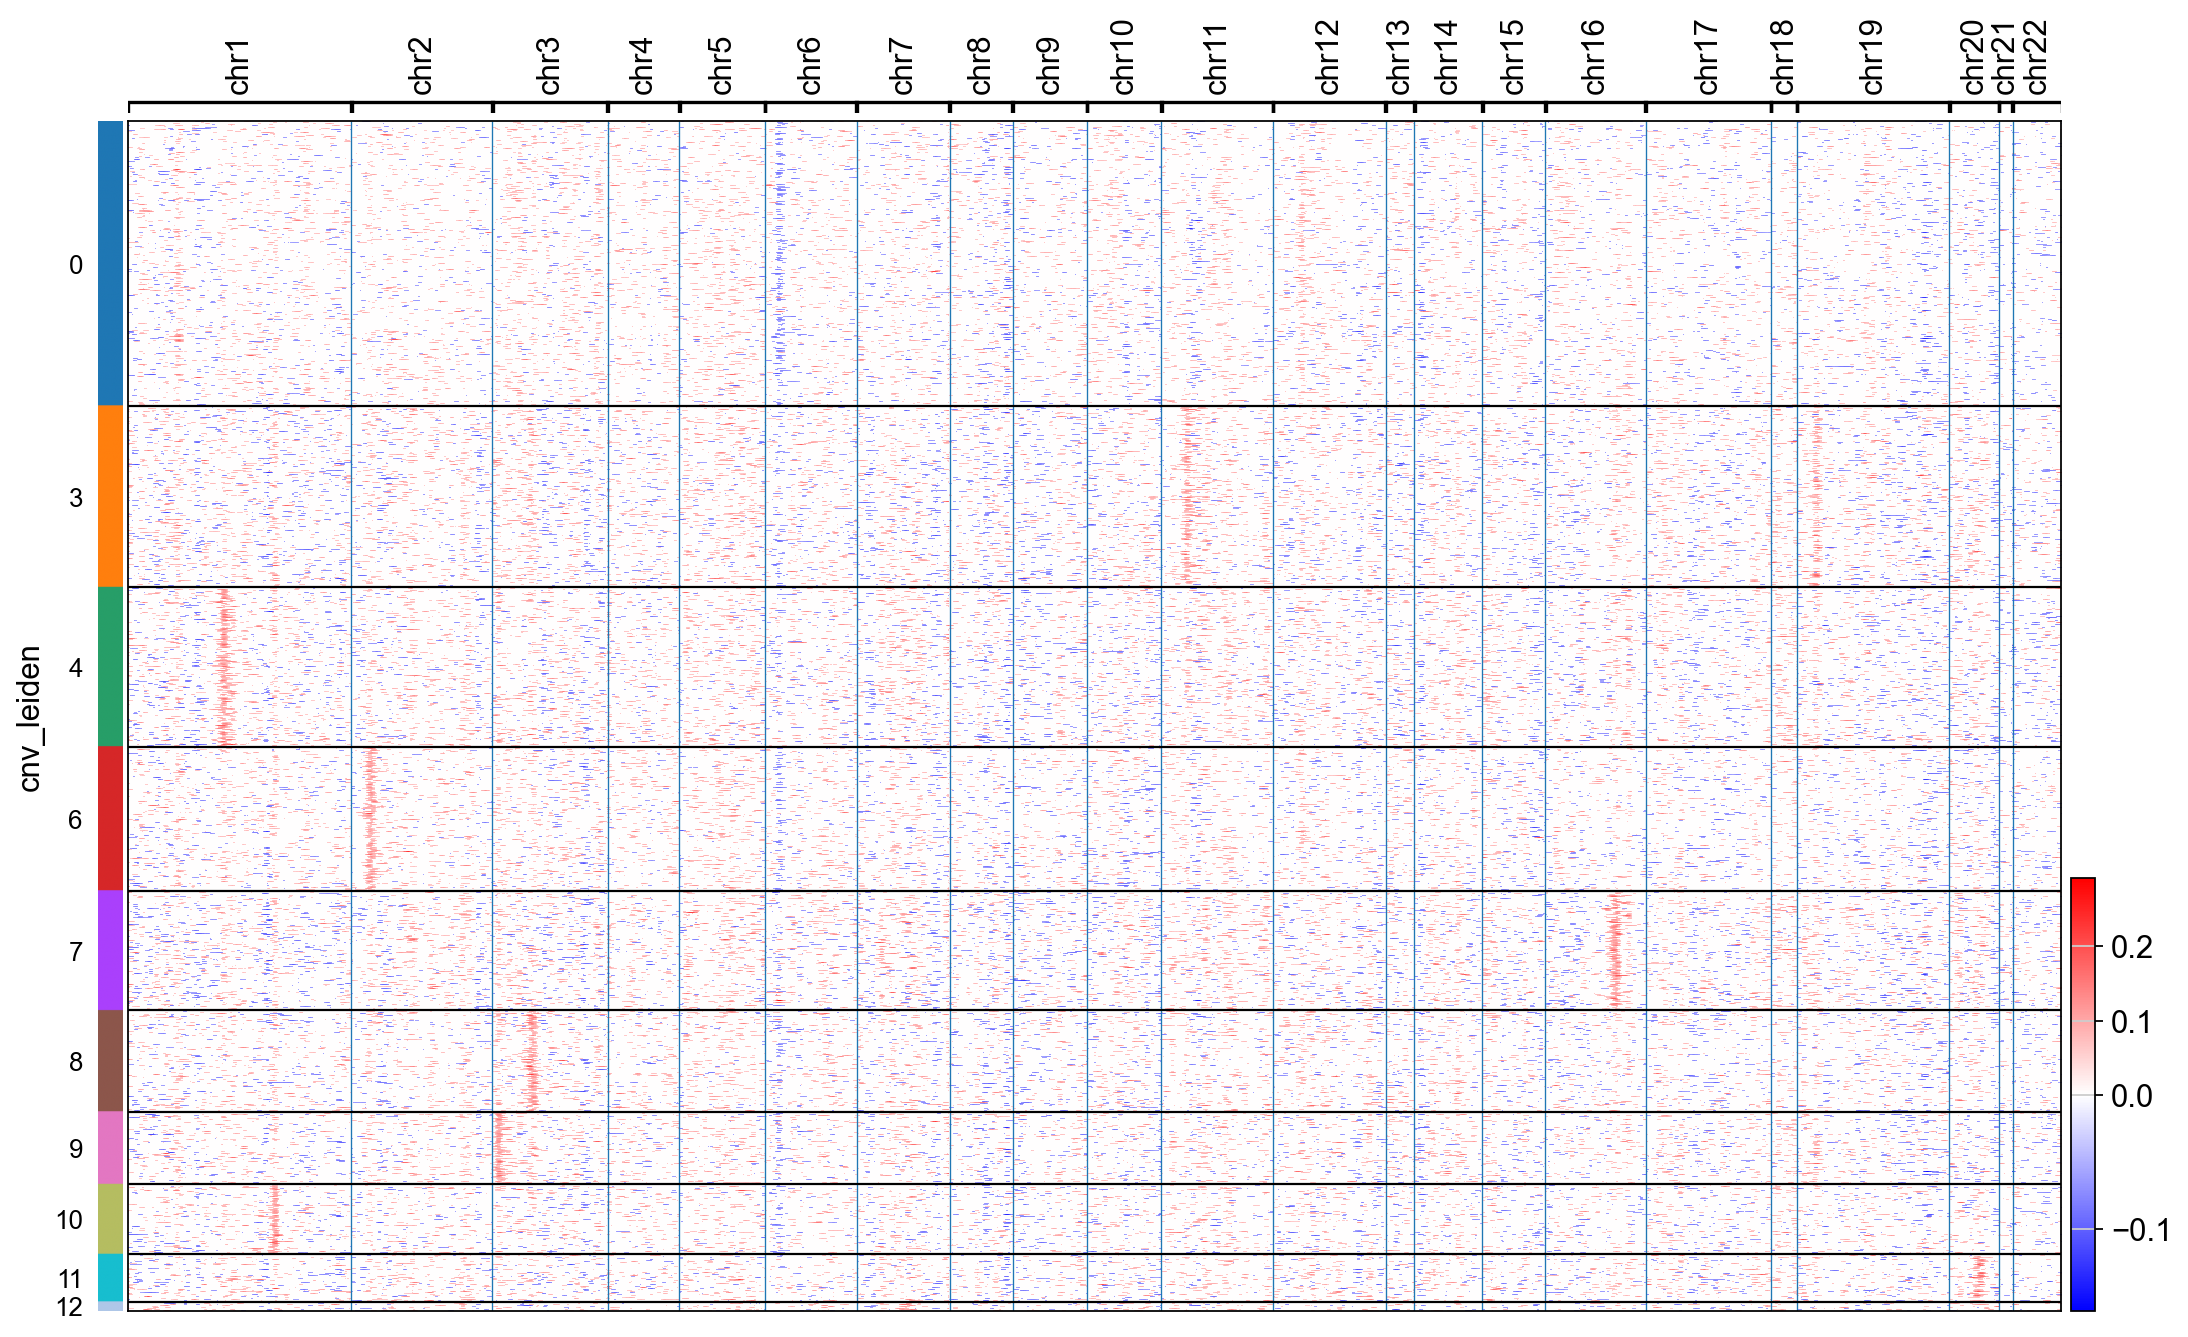

In [70]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_calls"] == "normal", :])